**Neste código é realizado o treinamento de uma CNN (Unet+Mobilinet) para segmentação de parafusos.**


Para treinar o modelo de segmentação, foi usada uma biblioteca de aprendizado profundo conhecida como Fastai, que usa Pytorch. Essa biblioteca fornece facilmente resultados de última geração em domínios de aprendizado profundo padrão, é de facil uso, tem flexibilidade e desempenho. https://docs.fast.ai/

In [1]:
#Importar bibliotecas necessárias para Fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [2]:
warnings.filterwarnings("ignore")

In [3]:
#Associa o endereço onde a pasta está localizada com as imagens e rótulos
path = Path('/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon')

In [4]:
#o arquivo codes.txt estabelece as classes da imagem neste caso background e parafuso
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['background', 'parafuso'], dtype='<U10')

In [5]:
# Armazena os nomes das imagens da pasta images1
fnames = get_image_files(path, recurse=True, folders='images')

In [6]:
# Esta função permite associar as imagens aos seus respectivos rótulos (os rótulos de cada imagem têm o mesmo nome mais um _P)
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [7]:
# Cria batches de tamanho 4 associando as imagens com seus rótulos e aplica uma normalização
dls = SegmentationDataLoaders.from_label_func(
    path, bs=4, 
    fnames = fnames, 
    label_func = label_func, 
    codes = codes,  
    batch_tfms=[Normalize.from_stats(*imagenet_stats)],
    num_workers = 0) 

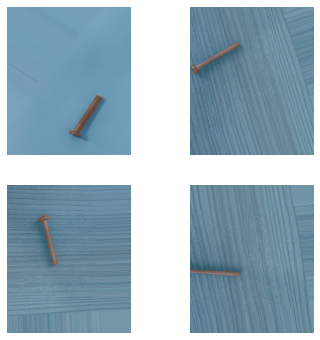

In [8]:
# Apresenta um Batch
dls.show_batch(max_n=4,vmin=0)

In [9]:
# Retorna o índice Jaccard, ou valor de Interseção sobre União (IoU) (Métrica para validar o modelo) fonte https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/2 
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [10]:
# Cria o modelo baseado na arquitetura unet com a arquitetura resnet34 como backbone 
learn = unet_learner(dls, resnet34,metrics=[IoU])

In [11]:
# Treinamento e ajuste fino da rede com uma taxa de aprendizagem de 2e-3  
# Número de epocas treinando ás ultimas camadas da rede=1
# Número de epocas treinando toda a rede=5
# Técnica de regularização: Weight decay
learn.fine_tune(5,base_lr=2e-3,freeze_epochs=1,wd=0.9e-3) 

epoch,train_loss,valid_loss,IoU,time
0,0.030304,0.009455,0.690779,02:12


epoch,train_loss,valid_loss,IoU,time
0,0.006928,0.006255,0.737793,01:23
1,0.006589,0.006434,0.736257,01:22
2,0.005224,0.004162,0.753828,01:22
3,0.004263,0.003956,0.758350,01:22
4,0.003617,0.003982,0.760617,01:23


In [12]:
# Armazena os pesos do modelo
learn.save('/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon/models/modelSegmentation_URes')

Path('/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon/models/modelSegmentation_URes.pth')

In [13]:
# Armazena a arquitetura completa da rede com os pesos
learn.export(fname='/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon/models/architectureSegmentation_URes.pkl')

In [ ]:
# Carrega o modelo ou arquitetura
learn.load('/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon/models/modelSegmentation_URes')
#learn=load_learner('/content/gdrive/MyDrive/Colab Notebooks/segmentacion/testeVisaoJhon/models/architectureSegmentation_URes.pkl')

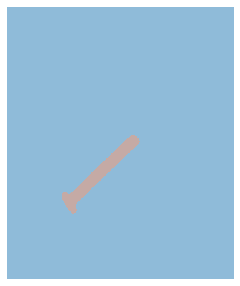

In [14]:
# Realiza a predição 
prediction = learn.predict(path/'teste/Parafuso 1.png')
prediction[0].show(figsize=(5,5))

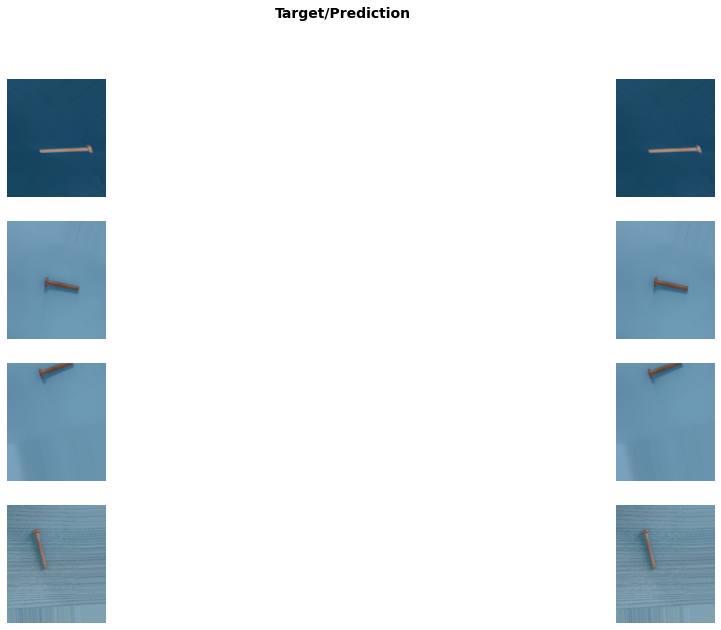

In [17]:
#Apresenta alguns resultados
learn.show_results(max_n=4, figsize=(20,10))